<a href="https://colab.research.google.com/github/haribalan9697/Applied-data-science/blob/main/supreme_court_judgement_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. **Importing libraries that are planned to be used in our process**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score
## for data
import pandas as pd

import re
import nltk
nltk.download('punkt')
## for language detection



import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# 2. Reading the dataset with pandas, dropping null values (calculated earlier at less than 5%) and creating a copy of the dataframe for the modelling process

In [2]:
df = pd.read_csv('/content/justice.csv', delimiter=',', encoding = "utf8")
df.dropna(inplace=True)
df.head()

,Unnamed: 0,ID,name,href,docket,term,first_party,second_party,facts,facts_len,majority_vote,minority_vote,first_party_winner,decision_type,disposition,issue_area
1,1,50613,Stanley v. Illinois,https://api.oyez.org/cases/1971/70-5014,70-5014,1971,"Peter Stanley, Sr.",Illinois,<p>Joan Stanley had three children with Peter ...,757,5,2,True,majority opinion,reversed/remanded,Civil Rights
2,2,50623,Giglio v. United States,https://api.oyez.org/cases/1971/70-29,70-29,1971,John Giglio,United States,<p>John Giglio was convicted of passing forged...,495,7,0,True,majority opinion,reversed/remanded,Due Process
3,3,50632,Reed v. Reed,https://api.oyez.org/cases/1971/70-4,70-4,1971,Sally Reed,Cecil Reed,"<p>The Idaho Probate Code specified that ""male...",378,7,0,True,majority opinion,reversed/remanded,Civil Rights
4,4,50643,Miller v. California,https://api.oyez.org/cases/1971/70-73,70-73,1971,Marvin Miller,California,"<p>Miller, after conducting a mass mailing cam...",305,5,4,True,majority opinion,vacated/remanded,First Amendment
5,5,50644,Kleindienst v. Mandel,https://api.oyez.org/cases/1971/71-16,71-16,1971,"Richard G. Kleindienst, Attorney General of th...","Ernest E. Mandel, et al.",<p>Ernest E. Mandel was a Belgian professional...,2282,6,3,True,majority opinion,reversed,First Amendment


In [3]:
df1 = df.copy()

In [4]:
df1.drop(columns=['Unnamed: 0', 'docket','name','first_party','second_party', 'issue_area', 
                 'facts_len', 'majority_vote', 'minority_vote', 'href', 'ID','term'], inplace=True)

# 3. Seperating the dataset into target variables and two groups of independent variables, one (df_cat) which requires one-hot encoding to be machine readable and the other (df_nlp) which is text data which needs to be cleaned for features to be engineered from it.

In [5]:
df_cat = df1[['decision_type', 'disposition']]

In [6]:
df_target = df1['first_party_winner']

In [7]:
df_nlp = df1['facts']

# 4. Resetting indices to avoid NaNs during concatenation and performing one-hot encoding

In [8]:
df_cat.reset_index(drop=True, inplace=True)
df_target.reset_index(drop=True, inplace=True)
df_nlp.reset_index(drop=True, inplace=True)

In [9]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
df_target= label_encoder.fit_transform(df_target)

In [10]:
df_target1 = pd.DataFrame(df_target, columns=['first_party_winner'])
df_target1

,first_party_winner
0,1
1,1
2,1
3,1
4,1
...,...
3093,1
3094,1
3095,0
3096,1


In [11]:
frames = [df_cat, df_target1]
df_concat = pd.concat(frames, axis=1, join='inner')
df_concat

,decision_type,disposition,first_party_winner
0,majority opinion,reversed/remanded,1
1,majority opinion,reversed/remanded,1
2,majority opinion,reversed/remanded,1
3,majority opinion,vacated/remanded,1
4,majority opinion,reversed,1
...,...,...,...
3093,majority opinion,reversed/remanded,1
3094,majority opinion,reversed/remanded,1
3095,majority opinion,affirmed,0
3096,majority opinion,vacated/remanded,1


In [12]:
df_nlp1 = pd.DataFrame(df_nlp, columns=['facts'])

In [13]:
df_nlp1['facts'] = df_nlp1['facts'].str.replace(r'<[^<>]*>', '', regex=True)
df_nlp1

,facts
0,Joan Stanley had three children with Peter Sta...
1,John Giglio was convicted of passing forged mo...
2,"The Idaho Probate Code specified that ""males m..."
3,"Miller, after conducting a mass mailing campai..."
4,Ernest E. Mandel was a Belgian professional jo...
...,...
3093,For over a century after the Alaska Purchase i...
3094,"Refugio Palomar-Santiago, a Mexican national, ..."
3095,Tarahrick Terry pleaded guilty to one count of...
3096,Joshua James Cooley was parked in his pickup t...


# 5. Performing initial cleaning and tokenizing the corpus, introducing a function to perform further cleaning and Lemmatization upon the data.

In [14]:
corpus = df_nlp1["facts"]
lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))

In [15]:
ps = nltk.stem.porter.PorterStemmer()
lem = nltk.stem.wordnet.WordNetLemmatizer()

In [16]:
nltk.download('stopwords')
lst_stopwords = nltk.corpus.stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [17]:

def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [18]:
nltk.download('wordnet')
df_nlp1["facts_clean"] = df_nlp1["facts"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [19]:
df_nlp1

,facts,facts_clean
0,Joan Stanley had three children with Peter Sta...,joan stanley three child peter stanley stanley...
1,John Giglio was convicted of passing forged mo...,john giglio convicted passing forged money ord...
2,"The Idaho Probate Code specified that ""males m...",idaho probate code specified male must preferr...
3,"Miller, after conducting a mass mailing campai...",miller conducting mass mailing campaign advert...
4,Ernest E. Mandel was a Belgian professional jo...,ernest e mandel belgian professional journalis...
...,...,...
3093,For over a century after the Alaska Purchase i...,century alaska purchase 1867 federal governmen...
3094,"Refugio Palomar-Santiago, a Mexican national, ...",refugio palomarsantiago mexican national grant...
3095,Tarahrick Terry pleaded guilty to one count of...,tarahrick terry pleaded guilty one count posse...
3096,Joshua James Cooley was parked in his pickup t...,joshua james cooley parked pickup truck side r...


# 6. Exploratory Data Analysis

In [20]:
df_nlp2 = pd.concat([df_nlp1,df_target1['first_party_winner']],axis=1, join='inner')

In [21]:
df_nlp2["first_party_winner"].value_counts()

1    2067
0    1031
Name: first_party_winner, dtype: int64

In [22]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

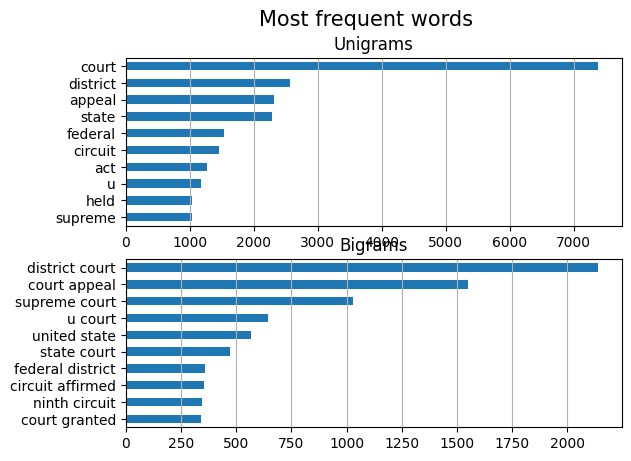

In [23]:
y = 1
corpus = df_nlp2[df_nlp2["first_party_winner"]== y]["facts_clean"]
lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
fig, ax = plt.subplots(nrows=2, ncols=1)
fig.suptitle("Most frequent words", fontsize=15)
#figure(figsize=(30, 24))
## unigrams
dic_words_freq = nltk.FreqDist(lst_tokens)
dtf_uni = pd.DataFrame(dic_words_freq.most_common(), 
                       columns=["Word","Freq"])
dtf_uni.set_index("Word").iloc[:10,:].sort_values(by="Freq").plot(
                  kind="barh", title="Unigrams", ax=ax[0], 
                  legend=False).grid(axis='x')
ax[0].set(ylabel=None)
    
## bigrams
dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))
dtf_bi = pd.DataFrame(dic_words_freq.most_common(), 
                      columns=["Word","Freq"])
dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(
                   string for string in x) )
dtf_bi.set_index("Word").iloc[:10,:].sort_values(by="Freq").plot(
                  kind="barh", title="Bigrams", ax=ax[1],
                  legend=False).grid(axis='x')
ax[1].set(ylabel=None)
plt.show()

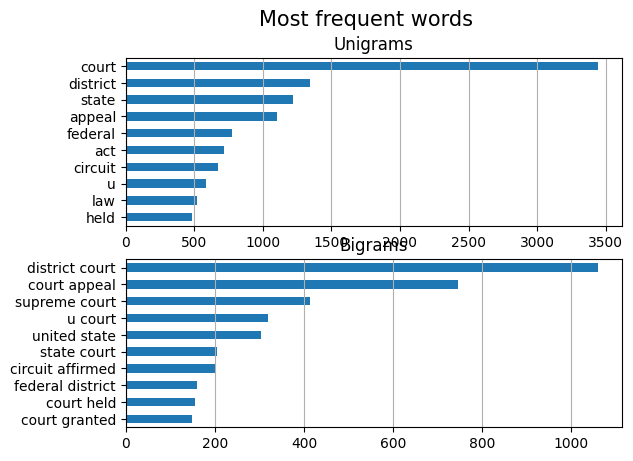

In [24]:
y = 0
corpus = df_nlp2[df_nlp2["first_party_winner"]== y]["facts_clean"]
lst_tokens = nltk.tokenize.word_tokenize(corpus.str.cat(sep=" "))
fig, ax = plt.subplots(nrows=2, ncols=1)
fig.suptitle("Most frequent words", fontsize=15)
#figure(figsize=(30, 24))
## unigrams
dic_words_freq = nltk.FreqDist(lst_tokens)
dtf_uni = pd.DataFrame(dic_words_freq.most_common(), 
                       columns=["Word","Freq"])
dtf_uni.set_index("Word").iloc[:10,:].sort_values(by="Freq").plot(
                  kind="barh", title="Unigrams", ax=ax[0], 
                  legend=False).grid(axis='x')
ax[0].set(ylabel=None)
    
## bigrams
dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))
dtf_bi = pd.DataFrame(dic_words_freq.most_common(), 
                      columns=["Word","Freq"])
dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(
                   string for string in x) )
dtf_bi.set_index("Word").iloc[:10,:].sort_values(by="Freq").plot(
                  kind="barh", title="Bigrams", ax=ax[1],
                  legend=False).grid(axis='x')
ax[1].set(ylabel=None)
plt.show()

In [25]:
import wordcloud

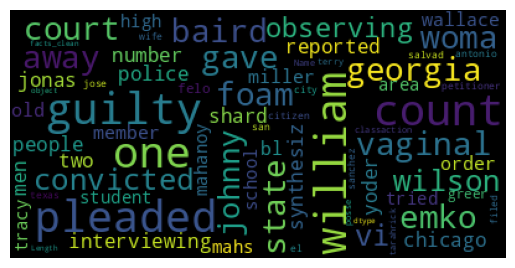

In [26]:
wc = wordcloud.WordCloud(background_color='black', max_words=100, 
                         max_font_size=35)
wc = wc.generate(str(corpus))
fig = plt.figure(num=1)
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.show()

In [27]:
import gensim.downloader as gensim_api
import gensim
import seaborn as sns

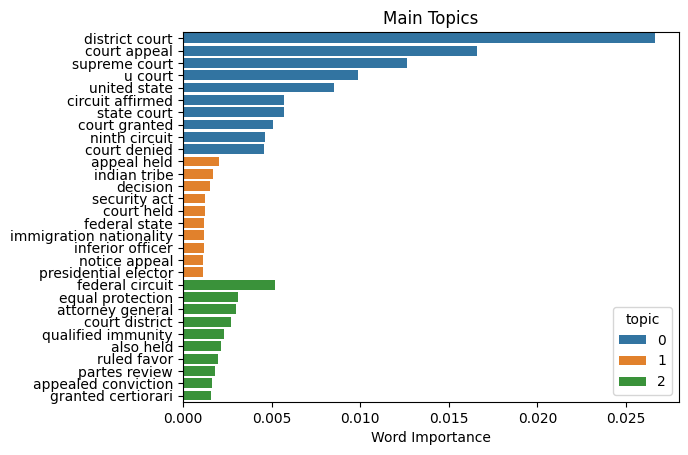

In [28]:
y = 1
corpus = df_nlp2[df_nlp2["first_party_winner"]==y]["facts_clean"]
## pre-process corpus
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i + 2]) for i in range(0, 
                     len(lst_words), 2)]
    lst_corpus.append(lst_grams)## map words to an id
id2word = gensim.corpora.Dictionary(lst_corpus)## create dictionary word:freq
dic_corpus = [id2word.doc2bow(word) for word in lst_corpus] ## train LDA
lda_model = gensim.models.ldamodel.LdaModel(corpus=dic_corpus, id2word=id2word, num_topics=7, random_state=123, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
   
## output
lst_dics = []
for i in range(0,3):
    lst_tuples = lda_model.get_topic_terms(i)
    for tupla in lst_tuples:
        lst_dics.append({"topic":i, "id":tupla[0], 
                         "word":id2word[tupla[0]], 
                         "weight":tupla[1]})
dtf_topics = pd.DataFrame(lst_dics, 
                         columns=['topic','id','word','weight'])

## plot
fig, ax = plt.subplots()
sns.barplot(y="word", x="weight", hue="topic", data=dtf_topics, dodge=False, ax=ax).set_title('Main Topics')
ax.set(ylabel="", xlabel="Word Importance")
plt.show()

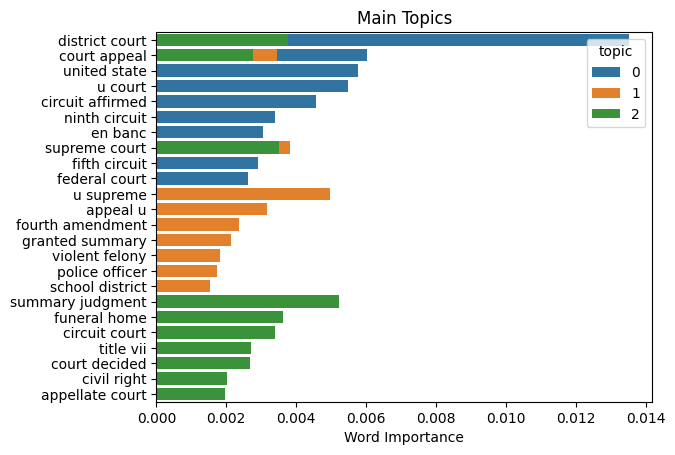

In [29]:
y = 0
corpus = df_nlp2[df_nlp2["first_party_winner"]==y]["facts_clean"]
## pre-process corpus
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i + 2]) for i in range(0, 
                     len(lst_words), 2)]
    lst_corpus.append(lst_grams)## map words to an id
id2word = gensim.corpora.Dictionary(lst_corpus)## create dictionary word:freq
dic_corpus = [id2word.doc2bow(word) for word in lst_corpus] ## train LDA
lda_model = gensim.models.ldamodel.LdaModel(corpus=dic_corpus, id2word=id2word, num_topics=7, random_state=123, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
   
## output
lst_dics = []
for i in range(0,3):
    lst_tuples = lda_model.get_topic_terms(i)
    for tupla in lst_tuples:
        lst_dics.append({"topic":i, "id":tupla[0], 
                         "word":id2word[tupla[0]], 
                         "weight":tupla[1]})
dtf_topics = pd.DataFrame(lst_dics, 
                         columns=['topic','id','word','weight'])

## plot
fig, ax = plt.subplots()
sns.barplot(y="word", x="weight", hue="topic", data=dtf_topics, dodge=False, ax=ax).set_title('Main Topics')
ax.set(ylabel="", xlabel="Word Importance")
plt.show()

# 7. Introducing Count Vectorizer to derive features from textual data.

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

In [31]:
vectorizer = CountVectorizer()

In [32]:
df_nlp2 = pd.concat([df_nlp1,df_target1['first_party_winner']],axis=1, join='inner')

In [33]:
xfeatures = df_nlp2['facts_clean']
ylabel = df_nlp2['first_party_winner']

# 8. Using sklearn train_test_split and Pipeline to fit and score the model on Logistic Regression, RandomForest and K-NearestNeighbors on the newly engineered features

In [34]:
X_train, X_test, y_train, y_test = train_test_split(xfeatures,ylabel, test_size=0.25)

In [35]:
pipe = Pipeline(steps=[('cv',CountVectorizer()),('lr',LogisticRegression(solver='liblinear'))])

In [36]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('cv', CountVectorizer()),
                ('lr', LogisticRegression(solver='liblinear'))])

In [37]:
pipe.score(X_test,y_test)

0.5948387096774194

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [39]:
pipe1= Pipeline(steps=[('cv',CountVectorizer()),('rf',RandomForestClassifier())])

In [40]:
pipe1.fit(X_train,y_train)

Pipeline(steps=[('cv', CountVectorizer()), ('rf', RandomForestClassifier())])

In [41]:
pipe1.score(X_train,y_train)

1.0

In [42]:
pipe1.score(X_test,y_test)

0.6580645161290323

In [43]:
pipe2= Pipeline(steps=[('cv',CountVectorizer()),('rf',KNeighborsClassifier(n_neighbors=3))])

In [44]:
pipe2.fit(X_train,y_train)

Pipeline(steps=[('cv', CountVectorizer()),
                ('rf', KNeighborsClassifier(n_neighbors=3))])

In [45]:
pipe2.score(X_train,y_train)

0.8639690055962118

In [46]:
pipe2.score(X_test,y_test)

0.6374193548387097

# 9. Now including the one-hot encoded features within our model.

In [47]:
df_nl1=pd.concat([df_nlp2,df_cat],axis=1,join='inner')

In [48]:
df_nl1

,facts,facts_clean,first_party_winner,decision_type,disposition
0,Joan Stanley had three children with Peter Sta...,joan stanley three child peter stanley stanley...,1,majority opinion,reversed/remanded
1,John Giglio was convicted of passing forged mo...,john giglio convicted passing forged money ord...,1,majority opinion,reversed/remanded
2,"The Idaho Probate Code specified that ""males m...",idaho probate code specified male must preferr...,1,majority opinion,reversed/remanded
3,"Miller, after conducting a mass mailing campai...",miller conducting mass mailing campaign advert...,1,majority opinion,vacated/remanded
4,Ernest E. Mandel was a Belgian professional jo...,ernest e mandel belgian professional journalis...,1,majority opinion,reversed
...,...,...,...,...,...
3093,For over a century after the Alaska Purchase i...,century alaska purchase 1867 federal governmen...,1,majority opinion,reversed/remanded
3094,"Refugio Palomar-Santiago, a Mexican national, ...",refugio palomarsantiago mexican national grant...,1,majority opinion,reversed/remanded
3095,Tarahrick Terry pleaded guilty to one count of...,tarahrick terry pleaded guilty one count posse...,0,majority opinion,affirmed
3096,Joshua James Cooley was parked in his pickup t...,joshua james cooley parked pickup truck side r...,1,majority opinion,vacated/remanded


In [49]:
xfeatures1 = df_nl1[['facts_clean','decision_type','disposition']]
ylabel1 = df_nl1['first_party_winner']

In [50]:
df_cat1 = pd.get_dummies(df_cat['decision_type'])

In [51]:
df_cat2 = pd.get_dummies(df_cat['disposition'])

In [52]:
df_cat3=pd.concat([df_cat2,df_cat1],axis=1,join='inner')

In [53]:
df_cat3.columns

Index(['affirmed', 'none', 'reversed', 'reversed in-part',
       'reversed in-part/remanded', 'reversed/remanded', 'vacated',
       'vacated in-part/remanded', 'vacated/remanded',
       'dismissal - improvidently granted', 'dismissal - moot',
       'dismissal - other', 'equally divided', 'majority opinion',
       'opinion of the court', 'per curiam', 'plurality opinion'],
      dtype='object')

In [54]:
df_cat3=pd.concat([df_cat3,df_nl1['first_party_winner']],axis=1,join='inner')

In [55]:
vectorize=CountVectorizer()

In [56]:
count_matrix = vectorize.fit_transform(df_nl1['facts_clean'])
count_array = count_matrix.toarray()
data_final = pd.DataFrame(data=count_array,columns = vectorize.get_feature_names_out())

In [57]:
data_final = pd.concat([data_final,df_cat3],axis=1,join='inner')

In [58]:
data_final

,011119,0125,01657,019,02,036539,04,041352,041581,045323,...,vacated/remanded,dismissal - improvidently granted,dismissal - moot,dismissal - other,equally divided,majority opinion,opinion of the court,per curiam,plurality opinion,first_party_winner
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3093,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3094,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3095,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3096,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1


In [59]:
X_train, X_test, y_train, y_test = train_test_split(data_final.drop(columns=['first_party_winner']),
                                                    data_final['first_party_winner'], 
                                                    test_size=0.3,random_state=10)

In [60]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_final = scaler.fit_transform(data_final)

# 10. Performing LDA and hyper-parameter tuning

In [61]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=200, random_state=0)
lda_data = lda.fit_transform(X_train)

In [62]:
lda_data_train = pd.DataFrame(data=lda_data)

In [63]:
lda_data_test = pd.DataFrame(data=lda.transform(X_test))

In [64]:
# Create the parameter grid based on the results of random search 
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [8,10,12,14],
    'max_features': [60,70,80,90,100],
    'min_samples_leaf': [2, 3, 4],
    'n_estimators': [100, 200, 300]
}# Create a based model
rf = RandomForestClassifier()# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [ ]:
grid_search.fit(lda_data_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 180 candidates, totalling 540 fits


In [67]:
rand=RandomForestClassifier(max_depth= 8, max_features = 100, min_samples_leaf = 2, n_estimators = 200)

In [68]:
rand.fit(lda_data_train,y_train)

RandomForestClassifier(max_depth=8, max_features=100, min_samples_leaf=2,
                       n_estimators=200)

In [69]:
rand.score(lda_data_train,y_train)

0.7011070110701108

In [ ]:
rand.score(lda_data_test,y_test)

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
y_pred1 = rand.predict(lda_data_test)
f1_score(y_test, y_pred1)

In [ ]:
model = XGBClassifier()
model.fit(lda_data_train, y_train)
y_pred = model.predict(lda_data_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
f1_score(y_test, y_pred1)

In [ ]:
knn=KNeighborsClassifier(n_neighbors=7)

In [ ]:
knn.fit(lda_data_train,y_train)

In [ ]:
knn.score(lda_data_train,y_train)

In [ ]:
knn.score(lda_data_test,y_test)

# 11. Deploying a LSTM Model to achieve higher accuracy

In [ ]:
import numpy as np
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

In [ ]:
n_unique_words = 10000 # cut texts after this number of words
maxlen = 2000
batch_size = 32

In [ ]:
model = Sequential()
model.add(Embedding(n_unique_words, 128, input_length=maxlen))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history=model.fit(lda_data_train, y_train,
           batch_size=batch_size,
           epochs=200,
           validation_data=[lda_data_test, y_test])

# **Thank you for taking the time to go through our submission. Any feedback is always welcome.**